# A tensorflow model for Dictionary Filter

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

2024-07-27 00:07:14.845952: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 00:07:15.216198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 00:07:15.917590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../Library')

from Metrics.RMSE import RMSE
from Metrics.CrossTab import CrossTab
from Modules.GaussianDF import GaussianDF as DictionaryFilter

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Test on Movie Lens 25M dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Recommended/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,7242,58197,3.5
1,21105,149680,4.0
2,6762,15512,4.5
3,2538,128,3.0
4,522,112086,5.0


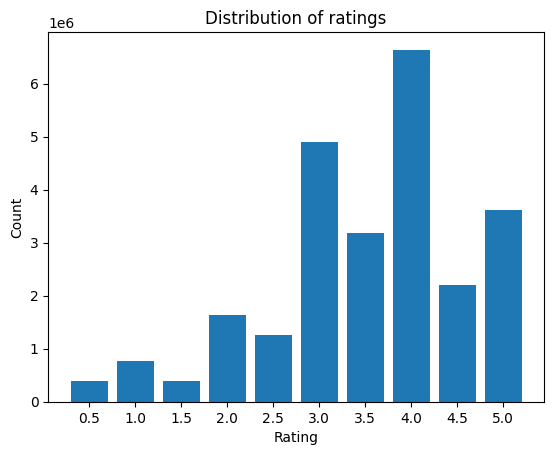

In [5]:
# Plot the distribution of ratings
rating_counts = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [6]:
from AdvancedModelSelection import user_based_train_val_test_split

# Split the dataset into train, validation, and test data
train_data, val_data, test_data = user_based_train_val_test_split(dataset, test_size=0.2, val_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (17998407, 3)
Validation data shape: (2002480, 3)
Test data shape: (4999208, 3)


In [7]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = 32
BATCH_SIZE = 32
TRAIN_LAMBDA = 2.0
INIT_SCALE = dataset['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 20

In [8]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-27 00:08:25.962643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 00:08:26.208661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 00:08:26.208713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 00:08:26.209854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 00:08:26.209901: I external/local_xla/xla/stream_executor

In [9]:
# Create dataset
def create_train_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

def create_full_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

## Experiments
### 1. Batch size vs train time vs RMSE

In [ ]:
# Initialize variables
batch_sizes = [8, 32, 128, 512]
rmse_train_results = np.zeros((len(batch_sizes), 5))
rmse_val_results = np.zeros((len(batch_sizes), 5))
train_timer = np.zeros((len(batch_sizes)))

for i, batch_size in enumerate(batch_sizes):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
    rmse_train = RMSE()
    rmse_val = RMSE()

    # Create the dataset
    dataset = create_train_dataset(batch_size)
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // batch_size, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train RMSE:", rmse_train.result().numpy())
        print("Val RMSE:", rmse_val.result().numpy())
        rmse_train_results[i, epoch] = rmse_train.result().numpy()
        rmse_val_results[i, epoch] = rmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

In [ ]:
# Save the results to a CSV file
results = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Train RMSE': rmse_train_results[:, -1],
    'Validation RMSE': rmse_val_results[:, -1],
    'Time (s)': train_timer
})

results.to_csv('Results/ML25M/DF/batch_sizes.csv', index=False)

### 2. Number of factors vs RMSE

In [ ]:
# Initialize variables
num_factors = [1, 2, 4, 8, 12, 16, 24, 32, 48, 64]
rmse_train_results = np.zeros((len(num_factors), 5))
rmse_val_results = np.zeros((len(num_factors), 5))
train_timer = np.zeros((len(num_factors)))

for i, num_factor in enumerate(num_factors):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, num_factor, INIT_SCALE, TRAIN_LAMBDA)
    rmse_train = RMSE()
    rmse_val = RMSE()

    # Create the dataset
    dataset = create_train_dataset()
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train RMSE:", rmse_train.result().numpy())
        print("Val RMSE:", rmse_val.result().numpy())
        rmse_train_results[i, epoch] = rmse_train.result().numpy()
        rmse_val_results[i, epoch] = rmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

In [ ]:
# Save the results to a CSV file
results = pd.DataFrame({
    'Number of Factors': num_factors,
    'Train RMSE': rmse_train_results[:, -1],
    'Validation RMSE': rmse_val_results[:, -1],
    'Time (s)': train_timer
})

results.to_csv('Results/ML25M/DF/num_factors.csv', index=False)

### 3. Number of epochs vs RMSE

In [10]:
# Initialize variables
rmse_train_results = np.zeros(NUM_EPOCHS)
rmse_val_results = np.zeros(NUM_EPOCHS)
rmse_test_results = np.zeros(NUM_EPOCHS)

# Create the model
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
rmse_train = RMSE()
rmse_val = RMSE()
rmse_test = RMSE()
crosstab_test = CrossTab(len(rating_counts.index))

# Create the dataset
dataset = create_full_dataset()

# Train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
    
    for train_batch, val_batch, test_batch in dataset:
        x = None
        
        if epoch == 0:
            x, v_updates = model(train_batch, return_V_updates=True)
            pd.DataFrame(v_updates.numpy()).to_csv('Results/ML25M/DF/V_updates.csv', index=False, header=False, mode='a')
        else:
            x = model(train_batch)
        
        rmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
        rmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
        rmse_test.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))
        
        if epoch == NUM_EPOCHS - 1:
            test_mask = tf.cast(tf.not_equal(test_batch, 0.0), tf.int32)
            test_batch = tf.cast((test_batch * 2.0) - 1.0, tf.int32)
            pred_batch = tf.cast(tf.round((tf.clip_by_value(tf.matmul(model.C, x), 1.0, 5.0) * 2.0) - 1.0), tf.int32)
            crosstab_test.update_state(test_batch, pred_batch, test_mask)
        
        progress_bar.update(1)
    
    progress_bar.close()

    print("Train RMSE:", rmse_train.result().numpy())
    print("Val RMSE:", rmse_val.result().numpy())
    print("Test RMSE:", rmse_test.result().numpy())
    rmse_train_results[epoch] = rmse_train.result().numpy()
    rmse_val_results[epoch] = rmse_val.result().numpy()
    rmse_test_results[epoch] = rmse_test.result().numpy()

Epoch 1: 100%|██████████| 5079/5079 [15:23<00:00,  5.50batch/s]


Train RMSE: 0.8053867
Val RMSE: 0.8596091
Test RMSE: 0.8603316


Epoch 2: 100%|██████████| 5079/5079 [12:46<00:00,  6.63batch/s]


Train RMSE: 0.8040749
Val RMSE: 0.85786194
Test RMSE: 0.8585235


Epoch 3: 100%|██████████| 5079/5079 [12:48<00:00,  6.61batch/s]


Train RMSE: 0.80355436
Val RMSE: 0.85707027
Test RMSE: 0.8576995


Epoch 4: 100%|██████████| 5079/5079 [12:51<00:00,  6.58batch/s]


Train RMSE: 0.80324876
Val RMSE: 0.85656345
Test RMSE: 0.85717237


Epoch 5: 100%|██████████| 5079/5079 [12:47<00:00,  6.62batch/s]


Train RMSE: 0.8030416
Val RMSE: 0.8561939
Test RMSE: 0.85679483


Epoch 6: 100%|██████████| 5079/5079 [12:47<00:00,  6.62batch/s]


Train RMSE: 0.80288905
Val RMSE: 0.8559156
Test RMSE: 0.85650164


Epoch 7: 100%|██████████| 5079/5079 [12:48<00:00,  6.61batch/s]


Train RMSE: 0.8027692
Val RMSE: 0.85568005
Test RMSE: 0.85626704


Epoch 8: 100%|██████████| 5079/5079 [12:50<00:00,  6.59batch/s]


Train RMSE: 0.8026717
Val RMSE: 0.855489
Test RMSE: 0.8560721


Epoch 9: 100%|██████████| 5079/5079 [12:46<00:00,  6.63batch/s]


Train RMSE: 0.8025924
Val RMSE: 0.8553232
Test RMSE: 0.85590184


Epoch 10: 100%|██████████| 5079/5079 [12:46<00:00,  6.63batch/s]


Train RMSE: 0.80252326
Val RMSE: 0.8551745
Test RMSE: 0.85575444


Epoch 11: 100%|██████████| 5079/5079 [12:42<00:00,  6.66batch/s]


Train RMSE: 0.8024621
Val RMSE: 0.855043
Test RMSE: 0.8556235


Epoch 12: 100%|██████████| 5079/5079 [12:42<00:00,  6.66batch/s]


Train RMSE: 0.8024083
Val RMSE: 0.8549283
Test RMSE: 0.85550505


Epoch 13: 100%|██████████| 5079/5079 [12:45<00:00,  6.64batch/s]


Train RMSE: 0.8023623
Val RMSE: 0.85482216
Test RMSE: 0.8554002


Epoch 14: 100%|██████████| 5079/5079 [12:46<00:00,  6.62batch/s]


Train RMSE: 0.80232215
Val RMSE: 0.8547261
Test RMSE: 0.8553041


Epoch 15: 100%|██████████| 5079/5079 [12:45<00:00,  6.63batch/s]


Train RMSE: 0.8022867
Val RMSE: 0.8546348
Test RMSE: 0.8552176


Epoch 16: 100%|██████████| 5079/5079 [12:42<00:00,  6.66batch/s]


Train RMSE: 0.8022512
Val RMSE: 0.85455287
Test RMSE: 0.8551389


Epoch 17: 100%|██████████| 5079/5079 [12:46<00:00,  6.62batch/s]


Train RMSE: 0.80221784
Val RMSE: 0.85447854
Test RMSE: 0.85506415


Epoch 18: 100%|██████████| 5079/5079 [12:48<00:00,  6.61batch/s]


Train RMSE: 0.8021872
Val RMSE: 0.85440505
Test RMSE: 0.85499483


Epoch 19: 100%|██████████| 5079/5079 [12:43<00:00,  6.65batch/s]


Train RMSE: 0.8021599
Val RMSE: 0.8543383
Test RMSE: 0.85493124


Epoch 20: 100%|██████████| 5079/5079 [13:09<00:00,  6.43batch/s]

Train RMSE: 0.8021331
Val RMSE: 0.8542715
Test RMSE: 0.85486805


In [11]:
# Save results to a CSV file
results = pd.DataFrame({
    'Train Results': rmse_train_results,
    'Validation Results': rmse_val_results,
    'Test Results': rmse_test_results
})
results.to_csv('Results/ML25M/DF/num_epochs.csv', index=False)

In [12]:
# Save the confusion matrix to a CSV file
crosstab = crosstab_test.result().numpy().astype(int)
crosstab_df = pd.DataFrame(crosstab, index=rating_counts.index, columns=rating_counts.index)
crosstab_df.to_csv('Results/ML25M/DF/confusion_matrix.csv')

In [13]:
# Save model weights
model_path = "Results/ML25M/DF/model_weights"
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write(model_path)

'Results/ML25M/DF/model_weights'

In [14]:
# Check variables in the model
tf.train.list_variables(model_path)

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/C/.ATTRIBUTES/VARIABLE_VALUE', [59047, 32]),
 ('model/V/.ATTRIBUTES/VARIABLE_VALUE', [32, 32])]

In [16]:
# Load model weights
model_path = "Results/ML25M/DF/model_weights"
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(model_path)

In [17]:
# Evaluate the model on the first test batch
dataset = create_full_dataset()
train_batch, val_batch, test_batch = next(iter(dataset))
x = model(train_batch)
pred = tf.matmul(model.C, x)

In [18]:
# Print the predictions
for i, j in tf.where(tf.not_equal(test_batch, 0.0)):
    print(f"i: {i.numpy()}, j: {j.numpy()}, True: {test_batch[i, j].numpy()}, Pred: {pred[i, j].numpy()}")

i: 0, j: 1, True: 3.5, Pred: 3.995647668838501
i: 1, j: 8, True: 5.0, Pred: 4.096056938171387
i: 2, j: 22, True: 5.0, Pred: 3.6339964866638184
i: 5, j: 22, True: 4.0, Pred: 3.986293077468872
i: 6, j: 7, True: 1.0, Pred: 3.783391237258911
i: 9, j: 6, True: 3.0, Pred: 3.311678409576416
i: 15, j: 24, True: 3.0, Pred: 3.8918912410736084
i: 16, j: 6, True: 4.0, Pred: 4.3066229820251465
i: 20, j: 24, True: 3.0, Pred: 3.503753423690796
i: 21, j: 11, True: 3.0, Pred: 2.94616961479187
i: 24, j: 22, True: 4.0, Pred: 4.249452114105225
i: 26, j: 11, True: 2.0, Pred: 2.6578543186187744
i: 30, j: 23, True: 4.0, Pred: 4.16536808013916
i: 31, j: 25, True: 4.5, Pred: 3.661339044570923
i: 33, j: 31, True: 3.0, Pred: 3.9441466331481934
i: 38, j: 31, True: 3.0, Pred: 3.699390411376953
i: 43, j: 19, True: 3.0, Pred: 2.4448301792144775
i: 49, j: 11, True: 5.0, Pred: 4.569371700286865
i: 53, j: 11, True: 2.0, Pred: 3.117525577545166
i: 60, j: 8, True: 4.0, Pred: 3.9546735286712646
i: 68, j: 28, True: 3.0, Pr

# Load and plot results

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/ML25M/DF/batch_sizes.csv')

batch_sizes = results['Batch Size']
train_rmse = results['Train RMSE']
val_rmse = results['Validation RMSE']
train_time = results['Time (s)']

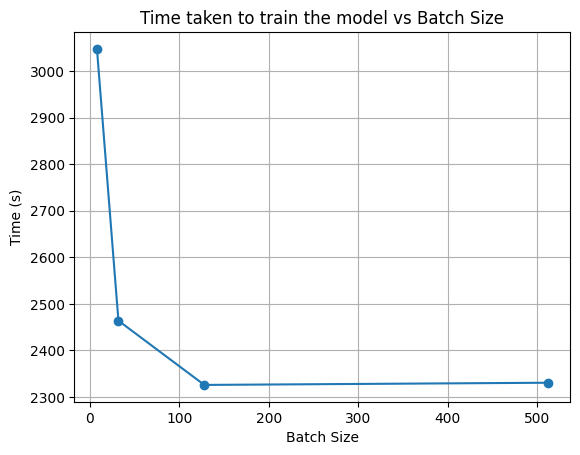

In [20]:
# Plot time taken to train the model vs batch size
plt.plot(batch_sizes, train_time, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Batch Size')
plt.grid()
plt.show()

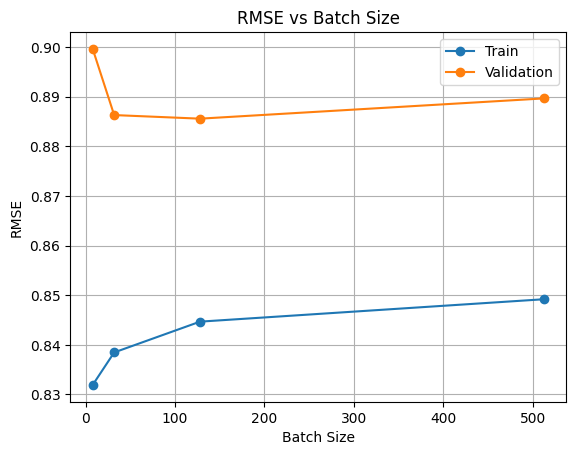

In [21]:
# Plot RMSE of the last epoch vs batch size
plt.plot(batch_sizes, train_rmse, marker='o', label='Train')
plt.plot(batch_sizes, val_rmse, marker='o', label='Validation')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.title('RMSE vs Batch Size')
plt.legend()
plt.grid()
plt.show()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/ML25M/DF/num_factors.csv')

num_factors = results['Number of Factors']
train_rmse = results['Train RMSE']
val_rmse = results['Validation RMSE']
time_taken = results['Time (s)']

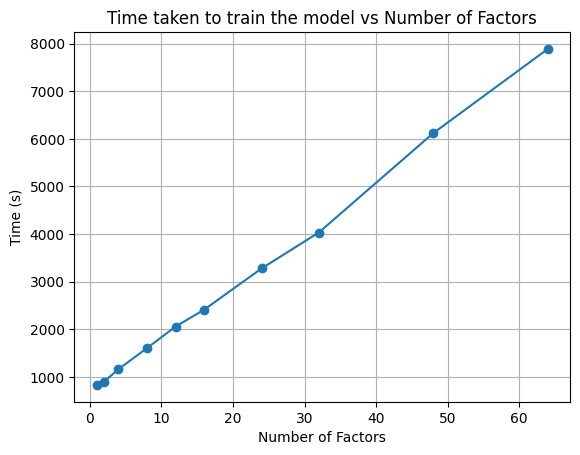

In [23]:
# Plot time taken to train the model vs number of factors
plt.plot(num_factors, time_taken, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Number of Factors')
plt.grid()
plt.show()

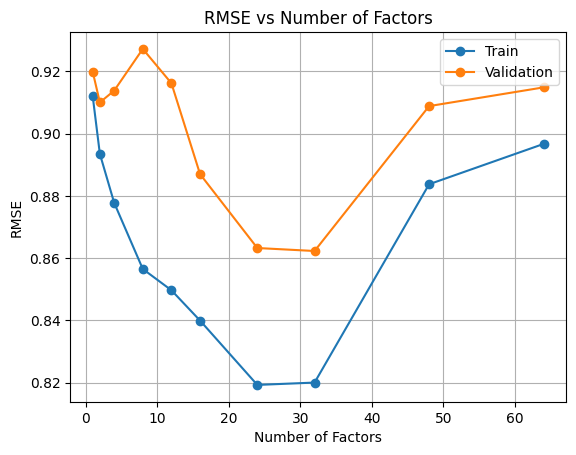

In [24]:
# Plot RMSE of the last epoch vs number of factors
plt.plot(num_factors, train_rmse, marker='o', label='Train')
plt.plot(num_factors, val_rmse, marker='o', label='Validation')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Factors')
plt.legend()
plt.grid()
plt.show()

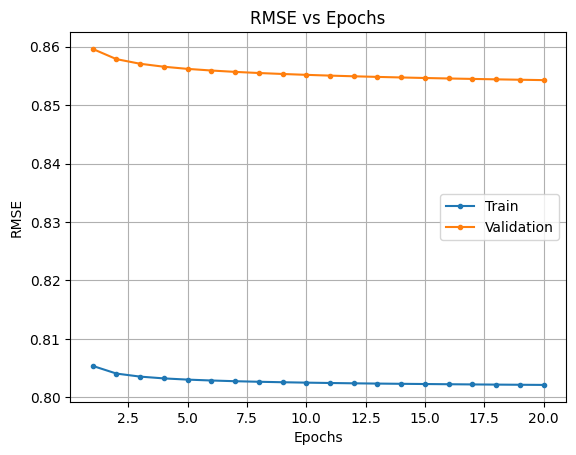

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
results = pd.read_csv('Results/ML25M/DF/num_epochs.csv')

rmse_train_results = results['Train Results']
rmse_val_results = results['Validation Results']
rmse_test_results = results['Test Results']

# Plot RMSE vs number of epochs
plt.plot(np.arange(1, NUM_EPOCHS+1), rmse_train_results, marker='.', label='Train')
plt.plot(np.arange(1, NUM_EPOCHS+1), rmse_val_results, marker='.', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE vs Epochs')
plt.legend()
plt.grid()
plt.show()

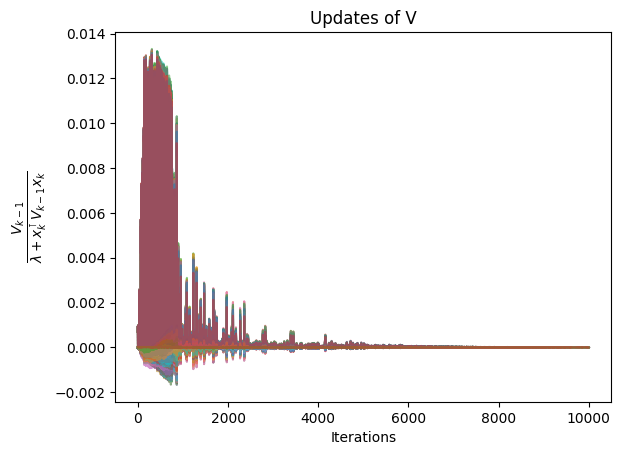

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the V updates
v_updates = pd.read_csv('Results/ML25M/DF/V_updates.csv', header=None)

# Plot the V updates
for i in range(len(v_updates.columns)):
    plt.plot(v_updates[i][:10000], alpha=0.5)

plt.xlabel('Iterations')
plt.ylabel('$\\frac{V_{k-1}}{\lambda + x_k^\intercal V_{k-1} x_k}$', fontsize=14)
plt.title('Updates of V')
plt.show()

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the confusion matrix from the CSV file
crosstab_df = pd.read_csv('Results/ML25M/DF/confusion_matrix.csv', index_col=0)
crosstab = crosstab_df.to_numpy()

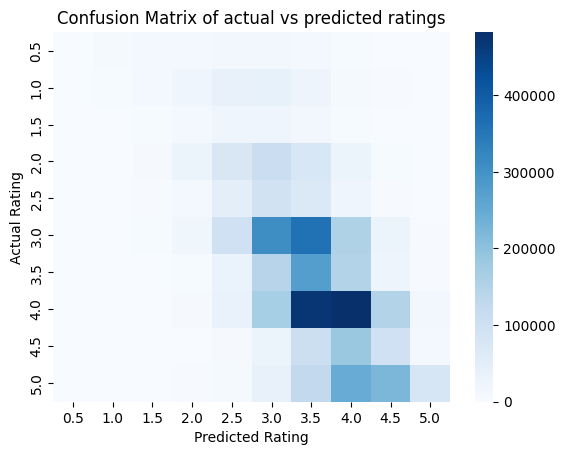

In [31]:
# Plot the confusion matrix
sns.heatmap(crosstab, annot=False, fmt="d", cmap='Blues', cbar=True)
plt.xticks(np.arange(0.5, 0.5 + len(rating_counts.index)), rating_counts.index.astype(str))
plt.yticks(np.arange(0.5, 0.5 + len(rating_counts.index)), rating_counts.index.astype(str))
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.title('Confusion Matrix of actual vs predicted ratings')
plt.show()